# Trabajo final de Aprendizaje No Supervisado

#### Coordinador: Adrien Felipe
#### Secretaria: Carolina Martínez
#### Revisor: Enrique Navarro

# Datasets
## Preparación
### Librerías

In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import itertools as it
import matplotlib.pyplot as plt

# Para las medidas extrínsecas
from sklearn import metrics, datasets
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, SpectralClustering
from sklearn.metrics import davies_bouldin_score, pairwise_distances
from sklearn.metrics.cluster import contingency_matrix
from scipy.cluster.hierarchy import linkage, cut_tree

# Eliminamos avisos molestos
import warnings
warnings.filterwarnings("ignore")

### Funciones de apoyo
#### Función de carga del dataset
Se crea una función para simplificar la carga del dataset, que acepta varios parámetros:
 - dataset_url: cadena con la ruta al recurso desde donde cargar el dataset.
 - separator (opcional): caracter de división en el origen del dataset.
 - class_position (opcional): ubicación en el dataset de la clase.
 - remove (opcional): qué atributos no se van a usar del dataset para eliminarlos al cargar.

In [25]:
def load_dataset(dataset_url: str, attributes: dict, separator: str = '\s+', class_position: int = None):
    """Load a dataset from a specified url into a pandas DataFrame.

    :param str dataset_url: an url from a text based dataset
    :param dict attributes: attributes to keep in dictionary form:
        key: attribute position, value: attribute name
    :param str separator: file separator.
    :param int class_position: column index where classes are defined (starts by 0)
        if left empty (None), no prediction class will be used (intrinsic case).
    """
    # Load dataset as a pandas DataFrame from a specified url.
    dataset = pd.read_csv(dataset_url, sep=separator, header=None)

    # Add class index to the indexes to extract.
    if class_position is not None:
        attributes[class_position] = 'classes'

    # Keep only desired attributes and classes.
    dataset = dataset[attributes]

    # Force all values to be numeric.
    for (column, values) in dataset.iteritems():
        # Do not transform classes.
        if column == class_position:
            continue

        # Coerce transforms non-numeric values into NaN.
        dataset[column] = pd.to_numeric(values, errors='coerce')

    # Remove all NaN rows.
    dataset.dropna(inplace=True)

    # Extrinsic case, dataset comes with its classes.
    if class_position is not None:
        # Extract classes.
        classes = dataset[class_position]
        # Remove classes from attributes.
        dataset.drop(class_position, axis=1, inplace=True)

    # Intrinsic case, dataset has no classes.
    else:
        classes = None

    # Set attributes title.
    dataset.rename(columns=attributes, inplace=True)

    return classes, dataset



#### Función de visualización
Creamos también una función para simplificar la visualización del dataset. En caso de usar más de dos atributos del dataset, usaremos el *pairplot* de seaborn para presentar los atributos de dos en dos. 

Recibe dos parámetros:
 - atributos: El DataFrame con los atributos a representar
 - clase (opcional): El DataFrame con la clase de cada instancia. 

In [26]:
def plot_dataset(dataset: pd.DataFrame, classes: np.array = None) -> None:
    # Combine all attributes two by two.
    combinations = list(it.combinations(dataset.columns, r=2))
    # Limit the number of plot columns.
    max_cols = 4
    cols = len(combinations) if len(combinations) <= max_cols else max_cols
    # From the columns number, set rows number.
    rows = int(np.ceil(len(combinations) / cols))

    # Calculate plot sizes depending on subplots number.
    size_x = int(13 * cols / max_cols) + 7
    size_y = 6 if rows * cols == 1 else 5 * rows

    # Build up all subplot combinations.
    fig, ax = plt.subplots(rows, cols, figsize=(size_x, size_y))
    for key, pair in enumerate(combinations):
        # Calculate plot axis position from sub-plot key.
        column = key % cols
        row = int(key / cols) % rows
        # Position needs to be a list when multiple rows.
        position = column if rows == 1 else (row, column)
        # Ax is not an array when single row and column.
        subplot = ax if rows * cols == 1 else ax[position]

        # Plot attributes values and titles.
        subplot.scatter(dataset[pair[0]], dataset[pair[1]], c=classes)
        subplot.set_title(str(pair[0]) + ' / ' + str(pair[1]))


### Funciones de cálculo de medidas extrínsecas:

In [27]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real == cats[i], cat_pred == clusts[j]))
                     for j in np.arange(clusts.size)]
                    for i in np.arange(cats.size)])
    return (mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l, :]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))


def medida_precision(mat, l, k):
    return mat[l, k] / sum(mat[:, k])


def medida_recall(mat, l, k):
    return mat[l, k] / sum(mat[l, :])


def medida_pureza(mat):
    totales = np.sum(mat, axis=0) / float(np.sum(mat))
    return np.sum([
        totales[k] * np.max(mat[:, k] / float(np.sum(mat[:, k])))
        for k in np.arange(mat.shape[1])
    ])


def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec + rec) == 0:
        return 0
    else:
        return 2 * prec * rec / (prec + rec)


def medida_f1(mat):
    totales = np.sum(mat, axis=1) / float(np.sum(mat))
    assign = np.sum([
        totales[l] * np.max([
            medida_f1_especifica(mat, l, k)
            for k in np.arange(mat.shape[1])
        ])
        for l in np.arange(mat.shape[0])
    ])
    return assign


def medida_entropia(mat):
    totales = np.sum(mat, axis=0) / float(np.sum(mat))
    relMat = mat / np.sum(mat, axis=0)
    logRelMat = relMat.copy()
    logRelMat[logRelMat == 0] = 0.0001  # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(logRelMat)
    return -np.sum([
        totales[k] * np.sum([
            relMat[l, k] * logRelMat[l, k]
            for l in np.arange(mat.shape[0])
        ])
        for k in np.arange(mat.shape[1])
    ])


#### Función de cálculo de las medidas extrínsecas
Función que calcula varias medidas cualitativas del agrupamiento.
 - Error, pureza, entropía, información mutua y F1 tal como se han visto en clase.
 - ARI mide la similaridad entre las clases y los predichos
 - Homogeneidad (todos los valores predichos son del clúster correcto)
 - Completación (todos los valores de una clase se predicen en el mismo clúster)
 - Medida V (media armónica de homogeneidad y completación). Parámetro beta (por defecto 1) para ponderar
 - Fowlkes-Mallows es la media geométrica de las parejas precision-recall
 - Silhouette
 - Calinski-Harabasz
 - Davies-Bouldin

In [28]:
def mediciones_extrinsecas(exDs, y_true, y_pred):
    confusion_matrix = matriz_confusion(y_true, y_pred)
    err = medida_error(confusion_matrix)
    pur = medida_pureza(confusion_matrix)
    F1 = medida_f1(confusion_matrix)
    ent = medida_entropia(confusion_matrix)
    im = metrics.adjusted_mutual_info_score(y_true, y_pred)
    
    ari = metrics.adjusted_rand_score(y_true, y_pred)
    hom = metrics.homogeneity_score(y_true, y_pred)
    com = metrics.completeness_score(y_true, y_pred)
    vm = metrics.v_measure_score(y_true, y_pred)
    fm = metrics.fowlkes_mallows_score(y_true, y_pred)
    media = (ari+im+hom+com+vm+fm)/6
    
    sil = metrics.silhouette_score(exDs, y_true, metric='euclidean')
    ch = metrics.calinski_harabasz_score(exDs, y_true)
    db = davies_bouldin_score(exDs, y_true)
    metricas = { "err":err, "pur":pur, "F1":F1, "ent":ent, "ari": ari, "im": im, "hom":hom, "com":com, "vm":vm, "fm":fm, "sil":sil, "ch":ch, "db":db, "media":media }
    return metricas


comparacion_extrinsecas = {"Kmedias":0,"Aglomerativo":0,"DBSCAN":0,"Deslizamiento":0,"Espectral":0}

### Funciones de cálculo de medidas intrínsecas:

In [29]:
def r2_score(dataset, prediction, centroids):
    """
    An intrinsic R² score metric, as sklearn one is extrinsic only.
    """
    attributes_mean = np.mean(dataset, axis=0)
    labels = np.sort(np.unique(prediction))
    numerator = np.sum([
        np.sum(np.sum(dataset[prediction == label] - centroids[label], axis=1) ** 2)
        for label in labels
    ])
    denominator = np.sum(np.sum(dataset - attributes_mean, 1) ** 2)

    return 1 - numerator / denominator


def distancia_euclidiana(x, y):
    return np.sqrt(np.sum((x - y) ** 2))


def distance_matrix(X, distancia):
    mD = np.zeros((X.shape[0], X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0], :], X[pair[1], :])
    return mD


def medida_I(dataset, prediction, centers, distance_function, p=1):
    attributes_mean = np.mean(dataset, axis=0)
    labels = np.sort(np.unique(prediction))
    distance_max = np.max(distance_matrix(centers, distance_function))

    num = np.sum([distance_function(instance, attributes_mean) for instance in dataset.values])

    den = len(labels) * np.sum([
        np.sum([
            distance_function(dataset.iloc[i], centers[k])
            for i in np.arange(dataset.shape[0])[prediction == labels[k]]
        ])
        for k in np.arange(centers.shape[0])
    ])

    return (num / den * distance_max) ** p

#### Función de cálculo de las medidas intrínsecas
Función que calcula varias medidas cualitativas del agrupamiento.
 - RMSSTD
 - R²
 - Silhouette
 - Calinski-Harabasz
 - Medida I
 - Davies-Boudin

In [30]:
def calculate_intrinsic_metrics(dataset, prediction):
    return {
        # 'RMSSTD': RMSSTD_score(dataset, model['prediction'], model['centers']),
        # 'R²': r2_score(dataset, model['prediction'], model['centers']),
        'Silueta': metrics.silhouette_score(dataset, prediction),
        'Calinski Harabasz': metrics.calinski_harabasz_score(dataset, prediction),
        # 'Medida I': medida_I(dataset, model['prediction'], model['centers'], distancia),
        'Davies Bouldin': metrics.davies_bouldin_score(dataset, prediction)
    }

## Selección

### Dataset extrínseca
 El origen de este dataset se remonta a datos usados en 1983 por la <i>American Statistical Association Exposition</i> y que se conservan en la Universidad de Carnegie Mellon, al que le faltan 8 instancias que se eliminaron para homogeneizar el dataset, ya que carecían del campo mpg.
 
 El dataset consta de:
 - 392 instancias
 - 8 atributos, que son:
     · mpg (millas por galón de combustible): de tipo continuo.
     · cylinders (cilindros): discreto multi evaluado.
     · displacement (cilindrada): continuo.
     · horsepower (caballos de potencia): continuo.
     · weight (peso): continuo
     · acceleration (aceleración): continuo
     · model-year (año del modelo): discrto multi evaluado.
     · origin (origen): discreto multi evaluado.
     · car name (nombre del coche): cadena (único para cada instancia)

Para el estudio que nos ocupa vamos a predecir el número de cilindros basándonos en la cilindrada y la potencia.


In [31]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
attributes = {0: 'mpg', 2: 'cilindrada', 3: 'potencia'}
extrinsic_classes, extrinsic_dataset = load_dataset(dataset_url, attributes, class_position=1)

Se descartan el resto de valores para mantener baja la dimensión del vector descriptor y simplificar así los cálculos.
Los datos vienen casi listos para trabajar con ellos. No se detectan campos vacíos:

In [32]:
print(extrinsic_dataset.isnull().any())

mpg           False
cilindrada    False
potencia      False
dtype: bool


Sin embargo, en la potencia hay un valor anómalo, un "?" usado donde se desconocía el dato, por lo que se ha incorporado a la función de carga de datos un filtro para eliminarlo, ajustable por parámetro (limpiarNA)

Vamos a observar la distribución de nuestra clase:

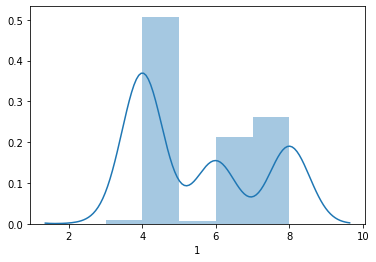

In [33]:
sns.distplot(extrinsic_classes)

Se observa una marcada preponderancia de los valores de cilindros 4,6 y 8. Asumimos que probablemente las instancias que no pertenezcan a estos tres grupos se agrupen dentro de ellos lo que va a conllevar un pequeño error de base al escoger agrupamientos.

Y la relación entre los atributos:

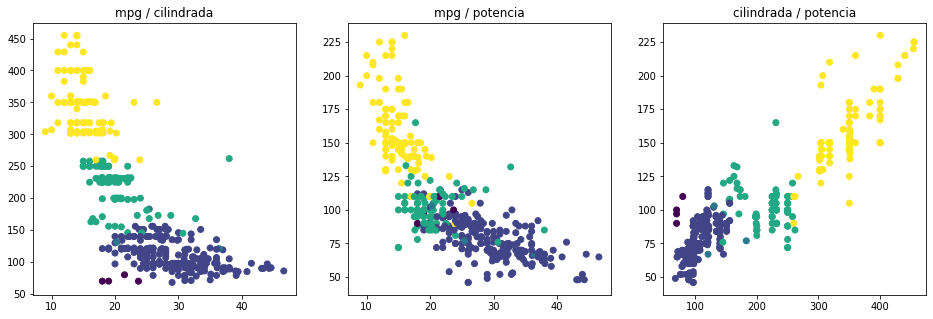

In [34]:
plot_dataset(extrinsic_dataset, extrinsic_classes)

### Dataset intrínseca
El dataset intrínseca **Aggregations** está generado de manera artificial por: *A. Gionis, H. Mannila, and P. Tsaparas, Clustering aggregation. ACM Transactions on Knowledge Discovery from Data (TKDD), 2007*


Este dataset está compuesto por 788 observaciones de 2 variables que abarcan un amplio rango numérico. En el conjunto de datos existen entre 5 a 7 grupos que se distribuyen en zonas particulares del rango de valores de las variables.


Cargamos nuestro dataset (*intrinsic_dataset*):

In [35]:
dataset_url = 'http://cs.joensuu.fi/sipu/datasets/Aggregation.txt'
attributes = {0: 'dim 1', 1: 'dim 2'}
intrinsic_dataset = load_dataset(dataset_url, attributes)

Podemos ver la relación siguiente entre atríbutos:

In [36]:
#plot_dataset(intrinsic_dataset)

***FALTA*** blablabla

# Análisis dataset extrínseca
## Algoritmos

### Algoritmo 1: K medias

Observando los datos es evidente que el número óptimo de clústers para K-means es 3.

err : 0.030612244897959218
pur : 0.9540816326530611
F1 : 0.9460000646748317
ent : 0.2102957674094942
ari : 0.8936763556149515
im : 0.8082470057660905
hom : 0.8102238340456043
com : 0.8901046962730058
vm : 0.8482878771447495
fm : 0.9348491588126387
sil : 0.3021422551209593
ch : 758.2371405820786
db : 1.0380069888685006
media : 0.86423148794284


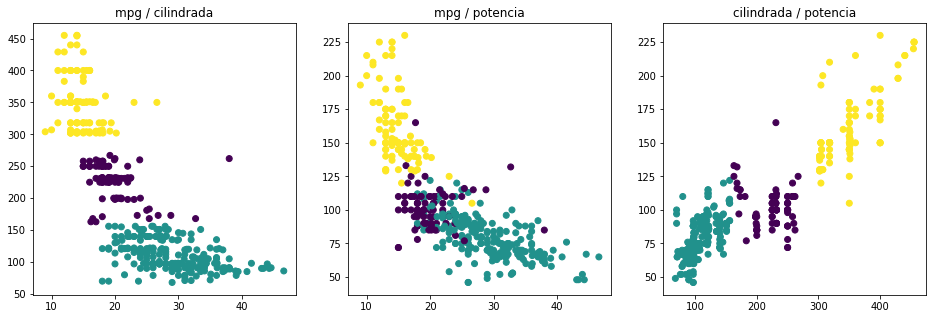

In [37]:
# Transformando las labels de texto a valores numéricos
y = np.unique(extrinsic_classes)
mapping = { key : value for key,value in zip(y,range(len(y)))}
labels_true = np.array([mapping[i] for i in extrinsic_classes])

kmeans_model = KMeans(n_clusters=3, random_state=1).fit(extrinsic_dataset)
labels_pred = kmeans_model.labels_
meds_kmeans_ext = mediciones_extrinsecas(extrinsic_dataset, labels_true, labels_pred)
# print(meds_kmeans_ext["err"])
for key,value in meds_kmeans_ext.items():
    print(key,":",value)
comparacion_extrinsecas["Kmedias"] = meds_kmeans_ext["media"]

    
prediction = kmeans_model.predict(extrinsic_dataset)
plot_dataset(extrinsic_dataset, prediction)

### ### Algoritmo 2: jerárquico aglomerativo

err : 0.08418367346938771
pur : 0.8979591836734694
F1 : 0.886247238759205
ent : 0.3526655593405822
ari : 0.7448063578342584
im : 0.6784981409707213
hom : 0.6817457691124379
com : 0.8021088737152909
vm : 0.7370456852577685
fm : 0.8507368210009014
sil : 0.3021422551209593
ch : 758.2371405820786
db : 1.0380069888685006
media : 0.7491569413152298


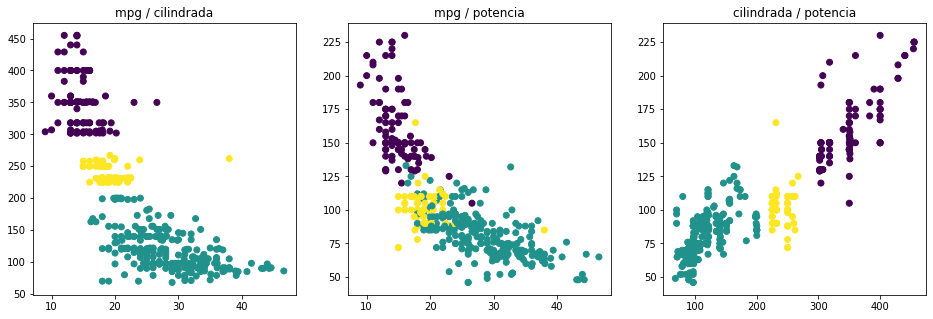

In [38]:
modelo = AgglomerativeClustering(n_clusters=3).fit(extrinsic_dataset)
labels_pred = modelo.labels_
meds_aglom_ext = mediciones_extrinsecas(extrinsic_dataset,extrinsic_classes,labels_pred)
for key,value in meds_aglom_ext.items():
    print(key,":",value)
comparacion_extrinsecas["Aglomerativo"] = meds_aglom_ext["media"]

plot_dataset(extrinsic_dataset, labels_pred)

### Algoritmo 3: DBSCAN

err : 0.12244897959183676
pur : 0.8954081632653061
F1 : 0.8740931990977399
ent : 0.324869599026371
ari : 0.7305105339753737
im : 0.7015968985864108
hom : 0.706829539662988
com : 0.7067854499787777
vm : 0.7068074941333192
fm : 0.8368863638374726
sil : 0.3021422551209593
ch : 758.2371405820786
db : 1.0380069888685006
media : 0.731569380029057
Mejor distancia identificada: 24.5


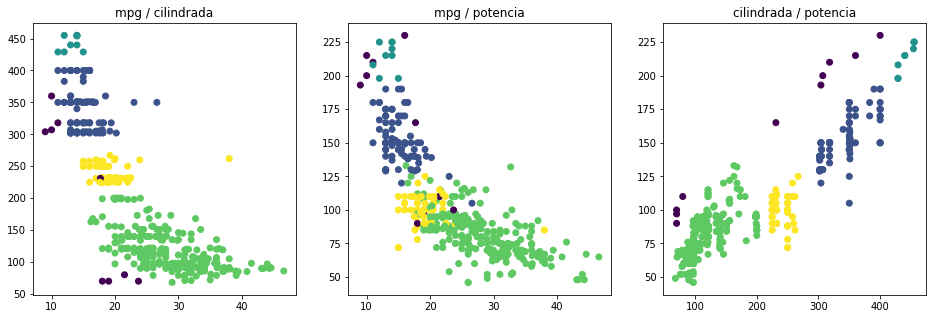

In [39]:
def calcular_DBSCAN(eps):
    modelo = DBSCAN(eps=eps).fit(extrinsic_dataset)
    labels_pred = modelo.labels_
    x = mediciones_extrinsecas(extrinsic_dataset,extrinsic_classes,labels_pred)
    media = (x["ari"]+x["im"]+x["hom"]+x["com"]+x["vm"]+x["fm"])/6
    return {"modelo":x,"mediciones":x,"prediction":labels_pred}

def repetir_dbscan(r):
    res = {"mediciones": {"media":0}}
    for i in np.arange(1,r+1):
        x = calcular_DBSCAN(i/2)
        if x["mediciones"]["media"] > res["mediciones"]["media"]:
            res = x
            res["distancia"] = i/2
    return res


eps = 50  # Distancias a probar (en pasos de 0.5)
best = repetir_dbscan(eps)
for key, value in best["mediciones"].items():
    print(key, ":", value)
print("Mejor distancia identificada:", best["distancia"])
comparacion_extrinsecas["DBSCAN"] = best["mediciones"]["media"]

plot_dataset(extrinsic_dataset, best["prediction"])

### Algoritmo 4: Deslizamiento de media

err : 0.06887755102040816
pur : 0.913265306122449
F1 : 0.9046437446045067
ent : 0.3177457137014363
ari : 0.7945053483693353
im : 0.7102893381963905
hom : 0.7132583121500359
com : 0.8036804284076778
vm : 0.7557744166561731
fm : 0.8761788636860638
sil : 0.3021422551209593
ch : 758.2371405820786
db : 1.0380069888685006
media : 0.7756144512442793


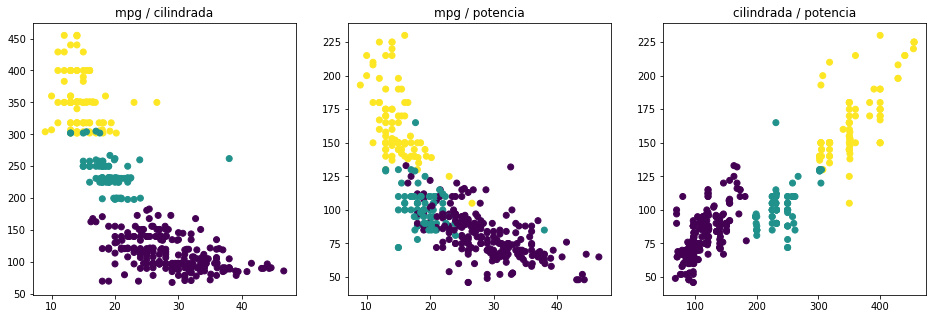

In [40]:
modelo = MeanShift().fit(extrinsic_dataset)
labels_pred = modelo.labels_
meds_meanshift_ext = mediciones_extrinsecas(extrinsic_dataset,extrinsic_classes,labels_pred)
for key,value in meds_meanshift_ext.items():
    print(key,":",value)
comparacion_extrinsecas["Deslizamiento"] = meds_meanshift_ext["media"]

plot_dataset(extrinsic_dataset, labels_pred)

### Algritmo 5: Espectral

Buscando mejor clustering espectral.
Probando de 1 a 50 vecinos más cercanos y repitiendo 20 veces.
Tiempo de ejecución estimado: 56 segundos.
El mejor espectral encontrado es con 13 vecinos y da una media de 0.5508552378357326
err : 0.5688775510204082
pur : 0.9617346938775511
F1 : 0.5642108415914922
ent : 0.14536258914276684
ari : 0.35371683876994714
im : 0.4593132844406973
hom : 0.8688211599285239
com : 0.46890455619171595
vm : 0.6090848004145542
fm : 0.5452907872689576
sil : 0.3021422551209593
ch : 758.2371405820786
db : 1.0380069888685006
media : 0.5508552378357326


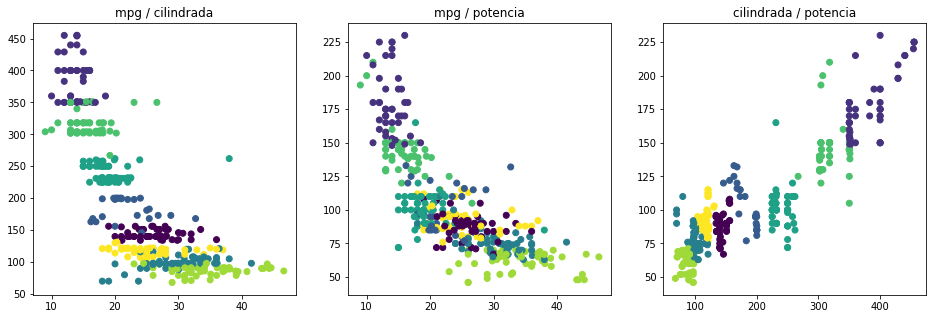

In [41]:
def mejor_espectral(nn):
    vecinos = 0
    media_max = 0
    modelo_fin = None
    for i in np.arange(nn):
        modelo = SpectralClustering(affinity='nearest_neighbors',n_neighbors=i+1).fit(extrinsic_dataset)
        labels_pred = modelo.labels_
        x = mediciones_extrinsecas(extrinsic_dataset,extrinsic_classes,labels_pred)
        if x["media"] > media_max:
            vecinos = i+1
            media_max = x["media"]
            modelo_fin = modelo
    return {"modelo":modelo_fin, "vecinos":vecinos, "mediciones":x, "prediction":labels_pred}

def repetir_espectral(v,r):
    print("Buscando mejor clustering espectral.\nProbando de 1 a",v,"vecinos más cercanos y repitiendo",r,"veces.\nTiempo de ejecución estimado:",int((v/53)*3*r),"segundos.")
    mejor = {"mediciones": {"media":0}}
    for i in np.arange(r+1):
        res = mejor_espectral(v)
        if res["mediciones"]["media"] > mejor["mediciones"]["media"]:
            mejor = res
    return mejor


vecinos = 50
repeticiones = 20
best = repetir_espectral(vecinos, repeticiones)
print("El mejor espectral encontrado es con", best["vecinos"], "vecinos y da una media de", best["mediciones"]["media"])
for key, value in best["mediciones"].items():
    print(key, ":", value)
comparacion_extrinsecas["Espectral"] = best["mediciones"]["media"]

plot_dataset(extrinsic_dataset, best["prediction"])

## Comparación algoritmos

Como se puede observar a continuación, si comparamos una media de las medidas calculadas, el algoritmo que mejor agrupa nuestros datos es K-medias:

In [42]:
for key,value in comparacion_extrinsecas.items():
    print(key,":",value)


Kmedias : 0.86423148794284
Aglomerativo : 0.7491569413152298
DBSCAN : 0.731569380029057
Deslizamiento : 0.7756144512442793
Espectral : 0.5508552378357326


# Análisis dataset intrínseca¶
## Algoritmos

### Algoritmo k-means

In [43]:
# Carol, te lo dejo aquí por si lo quieres usar para seleccionar el número de clusters óptimo
def kmeans_plot_clusters_selection(dataset: pd.DataFrame, max_clusters: int = 10):
    dataset = np.array(dataset)
    silhouette_values = []
    r2_values = []
    min_clusters = 2

    for k in np.arange(min_clusters, max_clusters):
        model = KMeans(n_clusters=k).fit(dataset)
        prediction = model.predict(dataset)
        centroids = model.cluster_centers_

        silhouette_values += [metrics.silhouette_score(dataset, prediction)]
        r2_values += [r2_score(dataset, prediction, centroids)]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.arange(min_clusters, max_clusters), silhouette_values, linestyle='-', marker='o')
    ax[0].set_xlabel("Número de clústeres")
    ax[0].set_ylabel("Medida de ancho de silueta")

    ax[1].plot(np.arange(min_clusters, max_clusters), r2_values, linestyle='-', marker='o')
    ax[1].set_xlabel("Número de clústeres")
    ax[1].set_ylabel("Medida de R cuadrado")

### Algoritmo 2

### Algoritmo 3

### Algoritmo 4

### Algoritmo 5

## Comparación algoritmos

# Conclusión